<a href="https://colab.research.google.com/github/pascualcam/aiml_code/blob/main/c10/c10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [50]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))

for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [51]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[4 5 6 7]
 [3 4 5 6]]
y =  [[8]
 [7]]
x =  [[5 6 7 8]
 [2 3 4 5]]
y =  [[9]
 [6]]
x =  [[1 2 3 4]
 [0 1 2 3]]
y =  [[5]
 [4]]


From c9:

In [52]:
def plot_series(time, series, format="-", start=0, end=None,):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [53]:
def trend(time, slope=0):
  return slope * time

In [54]:
def seasonal_pattern(season_time):
  return np.where(
      season_time < 0.4,
      np.cos(season_time * 2 * np.pi),
      1 / np.exp(3 * season_time)
  )

In [55]:
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

In [56]:
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [77]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.5)
amplitude = 15
slope = 0.09
noise_level = 6

# create a series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# update with noise
series += noise(time, noise_level, seed=42)

Adding windowed function

In [58]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(
      window_size + 1, shift=1, drop_remainder=True
  )
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(
      lambda window:
        (window[:-1], window[-1:])
  )
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [80]:
print(len(time))
print(time)

1461
[0.000e+00 1.000e+00 2.000e+00 ... 1.458e+03 1.459e+03 1.460e+03]


In [81]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [60]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [61]:
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)

for feature, label in dataset.take(1):
  print(feature)
  print(label)

tf.Tensor(
[[56.246693 51.28425  45.81952  54.622406 46.08484  40.333374 54.522903
  48.50339  38.934975 43.90775  39.69027  36.544308 50.298275 56.100857
  36.159195 47.837807 40.468735 41.365692 40.653236 38.946175]], shape=(1, 20), dtype=float32)
tf.Tensor([[44.347176]], shape=(1, 1), dtype=float32)


In [62]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [63]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(
    learning_rate=1e-6,
    momentum=0.9
))

In [64]:
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
46/46 [==============================] - 1s 6ms/step - loss: 734.0656
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 62.1061
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 58.6553
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 67.6153
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 57.0342
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: 56.8413
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 56.2555
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 53.6511
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 52.6172
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 52.4336
Epoch 11/100
46/46 [==============================] - 0s 3ms/step - loss: 52.6522
Epoch 12/100
46/46 [==============================] - 0s 3ms/step - loss: 51.8272
Epoch 13/100
46/46 [====

In [65]:
start_point = 1000
window_size = 20

In [66]:
print(series[start_point : start_point + window_size])

[110.02661  107.25494  102.14167   97.97915  106.12708  104.37574
 107.46318  105.98035  108.54404   99.112816 110.30619  103.66514
 115.00891   98.50013  113.129036 103.97882   98.96105  100.04455
 101.10417  105.64974 ]


In [67]:
print(series[start_point + window_size])

106.32034


In [68]:
print(model.predict(series[1000:1020][np.newaxis]))

1/1 [==============================] - 0s 72ms/step
[[107.05114]]


In [69]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time : time + window_size][np.newaxis]))

1/1 [==============================] - 0s 20ms/step


In [70]:
forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:, 0, 0]

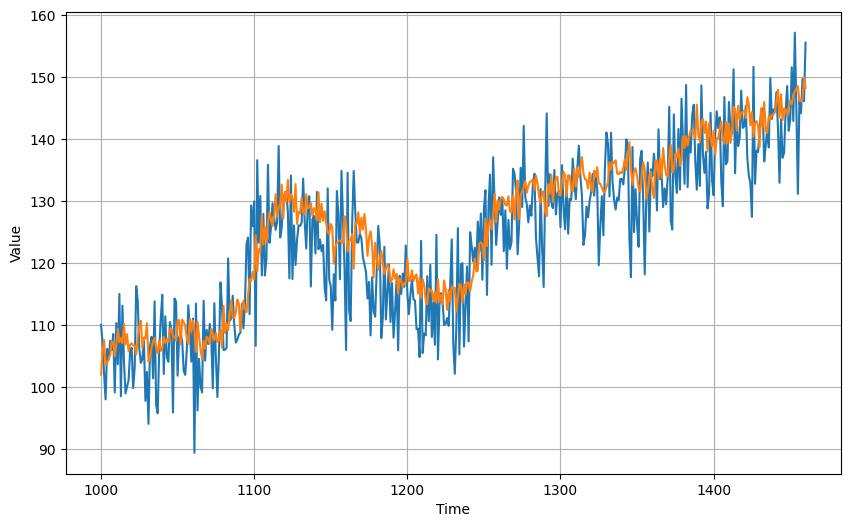

In [82]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)